# Training Neural Nets, Part 1


In [2]:
#Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

### MNIST Numbers again for testing:

In [42]:
#Load as usual:
from keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()


## Hold out some of the training data for validation:
######

## All but last 5,000 will be train data; last 5,000 will be validation
X_train, y_train = train_images[:-5000], train_labels[:-5000]

X_valid, y_valid = train_images[-5000:], train_labels[-5000:]

#Rename the test data for consistency:
X_test, y_test = test_images, test_labels


## And rescale everything to be between 0 and 1:
X_train, X_valid, X_test = X_train / 255., X_valid / 255., X_test / 255.

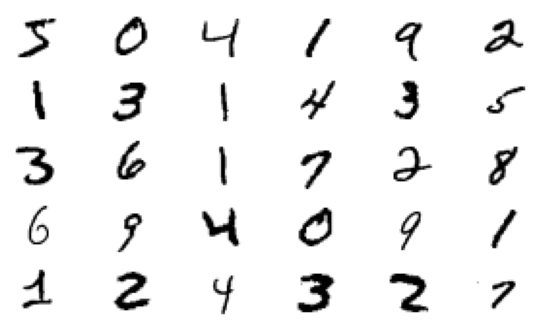

In [31]:
#Yet another reminder to ourselves of what these look like:
#######

fig1, ax1 = plt.subplots(5, 6, figsize=(7,4))

#Flatten for easier indexing
ax1 = ax1.flatten()

#And plot:
for i in range(30):

    im = ax1[i].imshow(X_train[i], cmap='gray_r')
    ax1[i].set_axis_off()
    

## Different Initialization Schemes

| Scheme | Activation Functions                     | $\sigma^2$    |
|--------|------------------------------------------|---------------|
| Glorot | None, tanh, sigmoid, softmax             | $1/fan_{avg}$ |
| He     | ReLU, Leaky ReLU, ELU, GELU, Swish, Mish | $2/fan_{in}$  |
| LeCun  | SELU                                     | $1/fan_{in}$  |

For uniform distribution use $r = \pm \sqrt{3 \sigma^2}$

Can specify these directly:

In [13]:

#Some options:
#he_normal
#he_uniform
#glorot_normal
#glorot_uniform
#lecun_normal
#lecun_uniform

hidden_layer1 = tf.keras.layers.Dense(32, activation="relu",
                                      kernel_initializer="he_uniform")


#### Can use `VarianceScaling` initializer:

- See https://www.tensorflow.org/api_docs/python/tf/keras/initializers/VarianceScaling

In [17]:
## Use fan_avg instead of fan_in:

he_avg_initializer = tf.keras.initializers.VarianceScaling(scale=2,
                                                           mode="fan_avg",
                                                           distribution="uniform")

hidden_layer1 = tf.keras.layers.Dense(32, activation="relu",
                                      kernel_initializer=he_avg_initializer)

## Activation Functions

- `LeakyReLU` and `PReLU` in `tf.keras.layers`

- See all at https://keras.io/api/layers/activation_layers/

In [23]:
#Can use:
hidden_layer1 = tf.keras.layers.Dense(32, activation="leaky_relu",
                                      kernel_initializer='he_normal')

#Or:
#Default alpha is 0.3, can change:
leaky_relu = tf.keras.layers.LeakyReLU(alpha=.1)

hidden_layer1 = tf.keras.layers.Dense(32, activation=leaky_relu,
                                      kernel_initializer='he_normal')

### Can use others through  `tf.keras.activations`:

- e.g., `sigmoid`, `tanh`, `relu`

In [36]:
hidden_layer1 = tf.keras.layers.Dense(32, activation=tf.keras.activations.relu,
                                      kernel_initializer='he_normal')


#Or just:
hidden_layer1 = tf.keras.layers.Dense(32, activation="relu",
                                      kernel_initializer='he_normal')

### Recall our other activation functions: ELU and SELU

- Exponential linear unit (ELU):

$$
\text{ELU}_{\alpha}(z) = \begin{cases}
  \alpha (e^z - 1), & \text{if } z < 0, \\
  z, & \text{if } z \geq 0.
\end{cases}
$$

- Scaled ELU (SELU):

$$
\text{SELU}(z) = 1.05 \text{ ELU}_{1.67}(z)
$$

SELU is self normalizing *if*:

- All inputs are normalized
- Weights are initialized using LeCun normal
- Plain MLP architecture
- No normalization

In [37]:
### To use:
hidden_layer1 = tf.keras.layers.Dense(32, activation="elu",
                                      kernel_initializer='he_normal')

hidden_layer1 = tf.keras.layers.Dense(32, activation="selu",
                                      kernel_initializer='lecun_normal')

### And more: GELU, Swish, Mish

- GELU:

$$
\text{GELU}(z) = z\Phi(z),
$$

where $\Phi(z)$ is the standard normal CDF

- Sigmoid linear unit (SiLU), aka Swish:

$$
\text{Swish}(z) = z \sigma(z)
$$

- Generalized Swish:

$$
\text{Swish}_{\beta}(z) = z \sigma(\beta z)
$$

Note that GELU is approximately equal to generalized Swish with $\beta = 1.702$.

- Mish:

$$
\text{mish}(z) = z \tanh{(\text{softplus}(z))},
$$

where
$$
\text{softplus}(z) = \log{(1 + \exp(z))}
$$

In [337]:
#We can use Swish and GELU out-of-the-box:
########

hidden_layer1 = tf.keras.layers.Dense(32, activation="swish",
                                      kernel_initializer='he_normal')

hidden_layer1 = tf.keras.layers.Dense(32, activation="gelu",
                                      kernel_initializer='he_normal')


### Try some  really deep networks:

- Let's use the Sequential API to create a net with many layers:

- First try with sigmoid, tanh, or ReLU activation:

In [91]:
#Sequential model:
model = tf.keras.Sequential()


model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))

#Add normalization:
normalization_layer = tf.keras.layers.Normalization(input_shape=(784,))
model.add(normalization_layer)

#Now add a bunch of hidden layers:
for layer in range(100):
    model.add(tf.keras.layers.Dense(100, activation="tanh", #Try sigmoid or tanh
                                    kernel_initializer="glorot_normal"))
    
    #model.add(tf.keras.layers.Dense(100, activation="relu",
    #                                kernel_initializer="he_normal"))
    
#And output layer:
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [92]:
#Compile and fit:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

normalization_layer.adapt(X_train.reshape(-1,784))

In [93]:
#Fit:
history = model.fit(X_train, y_train, epochs=5,
                    validation_data=(X_valid, y_valid))

Epoch 1/5
1719/1719 [==============================] - 23s 11ms/step - loss: 1.6988 - accuracy: 0.3555 - val_loss: 1.4073 - val_accuracy: 0.4458
Epoch 2/5
1719/1719 [==============================] - 18s 10ms/step - loss: 1.2792 - accuracy: 0.5127 - val_loss: 1.0588 - val_accuracy: 0.6466
Epoch 3/5
1719/1719 [==============================] - 18s 10ms/step - loss: 0.9505 - accuracy: 0.6839 - val_loss: 0.7625 - val_accuracy: 0.7606
Epoch 4/5
1719/1719 [==============================] - 17s 10ms/step - loss: 0.7399 - accuracy: 0.7840 - val_loss: 0.5971 - val_accuracy: 0.8520
Epoch 5/5
1719/1719 [==============================] - 18s 10ms/step - loss: 0.5904 - accuracy: 0.8483 - val_loss: 0.4751 - val_accuracy: 0.8856


#### Now with SELU:

- Need LeCun normalization

In [79]:
#Sequential model:
model2 = tf.keras.Sequential()


model2.add(tf.keras.layers.Flatten(input_shape=[28, 28]))

#Add normalization:
normalization_layer2 = tf.keras.layers.Normalization(input_shape=(784,))
model2.add(normalization_layer2)

#Now add a bunch of hidden layers:
for layer in range(100):
    model2.add(tf.keras.layers.Dense(100, activation="selu",
                                    kernel_initializer="lecun_normal"))
    
#And output layer:
model2.add(tf.keras.layers.Dense(10, activation="softmax"))

In [80]:
#Compile and fit:
model2.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

normalization_layer2.adapt(X_train.reshape(-1,784))

In [81]:
#Fit:
history = model2.fit(X_train, y_train, epochs=5,
                    validation_data=(X_valid, y_valid))

Epoch 1/5
1719/1719 [==============================] - 22s 11ms/step - loss: 1.5894 - accuracy: 0.4319 - val_loss: 1.0748 - val_accuracy: 0.6246
Epoch 2/5
1719/1719 [==============================] - 16s 9ms/step - loss: 0.9320 - accuracy: 0.7083 - val_loss: 0.7905 - val_accuracy: 0.7602
Epoch 3/5
1719/1719 [==============================] - 16s 9ms/step - loss: 0.9187 - accuracy: 0.7082 - val_loss: 0.6701 - val_accuracy: 0.7986
Epoch 4/5
1719/1719 [==============================] - 16s 9ms/step - loss: 0.7890 - accuracy: 0.7520 - val_loss: 0.6923 - val_accuracy: 0.7774
Epoch 5/5
1719/1719 [==============================] - 16s 9ms/step - loss: 0.6563 - accuracy: 0.8011 - val_loss: 0.6678 - val_accuracy: 0.7972


In [74]:
#Note could also rescale inputs like so:
##########

pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True) + 1e-16
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

## Batch Normalization in Keras

- To implement, add `BatchNormalization` layer before or after each hidden layer's activation function
- Can use an initial `BatchNormalization` layer to rescale the inputs, i.e., in lieu of a normalization layer

In [96]:
### Without Batch Normalization (or normalization):
model_base = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    
    #Now some standard dense layers:
    tf.keras.layers.Dense(300, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    #Output:
    tf.keras.layers.Dense(10, activation="softmax")
])

In [94]:
## Example:
########

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    
    #Acts to normalize input:
    tf.keras.layers.BatchNormalization(),
    
    #Now some standard dense layers, but with Batch Normalization:
    tf.keras.layers.Dense(300, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    
    #Output:
    tf.keras.layers.Dense(10, activation="softmax")
])

In [97]:
#Compile and train without Batch Norm:
model_base.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics="accuracy")

model_base.fit(X_train, y_train, epochs=5, validation_data=(X_valid, y_valid))

Epoch 1/5
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5536 - accuracy: 0.8528 - val_loss: 0.2456 - val_accuracy: 0.9318
Epoch 2/5
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2810 - accuracy: 0.9200 - val_loss: 0.1955 - val_accuracy: 0.9458
Epoch 3/5
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2300 - accuracy: 0.9347 - val_loss: 0.1674 - val_accuracy: 0.9550
Epoch 4/5
1719/1719 [==============================] - 4s 2ms/step - loss: 0.1951 - accuracy: 0.9442 - val_loss: 0.1504 - val_accuracy: 0.9576
Epoch 5/5
1719/1719 [==============================] - 4s 2ms/step - loss: 0.1695 - accuracy: 0.9516 - val_loss: 0.1298 - val_accuracy: 0.9656


In [95]:
#Compile and train with Batch norm:
#Note it is little slower but more accurate
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics="accuracy")

model.fit(X_train, y_train, epochs=5, validation_data=(X_valid, y_valid))

Epoch 1/5
1719/1719 [==============================] - 7s 3ms/step - loss: 0.4050 - accuracy: 0.8783 - val_loss: 0.1747 - val_accuracy: 0.9532
Epoch 2/5
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2065 - accuracy: 0.9386 - val_loss: 0.1319 - val_accuracy: 0.9648
Epoch 3/5
1719/1719 [==============================] - 6s 3ms/step - loss: 0.1580 - accuracy: 0.9537 - val_loss: 0.1138 - val_accuracy: 0.9690
Epoch 4/5
1719/1719 [==============================] - 5s 3ms/step - loss: 0.1319 - accuracy: 0.9606 - val_loss: 0.1059 - val_accuracy: 0.9714
Epoch 5/5
1719/1719 [==============================] - 5s 3ms/step - loss: 0.1120 - accuracy: 0.9664 - val_loss: 0.1000 - val_accuracy: 0.9726


In [103]:
## Look at structure:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_10 (Flatten)        (None, 784)               0         
                                                                 
 batch_normalization (Batch  (None, 784)               3136      
 Normalization)                                                  
                                                                 
 dense_962 (Dense)           (None, 300)               235500    
                                                                 
 batch_normalization_1 (Bat  (None, 300)               1200      
 chNormalization)                                                
                                                                 
 dense_963 (Dense)           (None, 100)               30100     
                                                                 
 batch_normalization_2 (Bat  (None, 100)             

In [107]:
## Let's check out the variables in the batch normalization layer:

#var.value for values
#Trainable means trainable by gradient descent
[(var.name, var.trainable) for var in model.layers[1].variables]

#Note gamma is output scale parameter
#beta is output offset parameter

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

### Batch Normalization Before Activation Function:

- Note that since Batch Normalization trains an offset parameter, we can use this instead of the bias term

In [101]:
model_batch_before = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    
    #Acts to normalize input:
    tf.keras.layers.BatchNormalization(),
    
    #Batch normalization with normalization before activation function:
    tf.keras.layers.Dense(300, kernel_initializer="he_normal", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    
    tf.keras.layers.Dense(100, kernel_initializer="he_normal", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    
    tf.keras.layers.Dense(10, activation="softmax")
])

In [102]:
#Test this guy out:
model_batch_before.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics="accuracy")

model_batch_before.fit(X_train, y_train, epochs=5, validation_data=(X_valid, y_valid))

Epoch 1/5
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4939 - accuracy: 0.8616 - val_loss: 0.1986 - val_accuracy: 0.9454
Epoch 2/5
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2450 - accuracy: 0.9297 - val_loss: 0.1467 - val_accuracy: 0.9582
Epoch 3/5
1719/1719 [==============================] - 5s 3ms/step - loss: 0.1903 - accuracy: 0.9441 - val_loss: 0.1243 - val_accuracy: 0.9642
Epoch 4/5
1719/1719 [==============================] - 5s 3ms/step - loss: 0.1576 - accuracy: 0.9540 - val_loss: 0.1142 - val_accuracy: 0.9674
Epoch 5/5
1719/1719 [==============================] - 5s 3ms/step - loss: 0.1338 - accuracy: 0.9608 - val_loss: 0.1068 - val_accuracy: 0.9668


## Gradient Clipping

- Can add gradient clipping to optimizer:

In [109]:
### Example:
### Clip all gradients to between -1 and 1
optimizer = tf.keras.optimizers.SGD(clipvalue=1.0)

#### Preserve direction?

- Use `clipnorm`:
- Clips to L2 norm at some max value

In [ ]:
optimizer = tf.keras.optimizers.SGD(clipnorm=1.0)

## Transfer Learning

- Use pretrained lower layers

Possible approach:

1. Freeze all pretrained layers
2. Train new upper layers
3. Unfreeze higher pretrained layers and train some more; use small learning rate
4. Can drop some pretrained layers if performance poor

<img src="pretrain.png" alt="Pretraining/Transfer" style="width:425px;"/>

### Example on MNIST Numbers

- Let's train a classifier to distinguish between numbers 0 through 7
    - Use all training data
    
- Then train a binary classifier to distringuish between 8 and 9
    - But only have 200 observations
    
    
Can we use layers from the first classifier for the second?

In [227]:
## Extract our data:
########

train_mask = (y_train != 8) & (y_train != 9)
valid_mask = (y_valid != 8) & (y_valid != 9)

#Numbers 0 through 7
X_train_07 = X_train[train_mask]
y_train_07 = y_train[train_mask]

X_valid_07 = X_valid[valid_mask]
y_valid_07 = y_valid[valid_mask]


#Just keep 200 observations in training and validation sets:
#And 8 and 9:
X_train_89 = X_train[~train_mask][:100]
y_train_89 = y_train[~train_mask][:100]

#And 8 and 9:
X_valid_89 = X_valid[~valid_mask][:100]
y_valid_89 = y_valid[~valid_mask][:100]

In [228]:
## Also relabel to 0 and 1 for 8 and 9:
y_train_89[y_train_89 == 8] = 0
y_train_89[y_train_89 == 9] = 1.
y_valid_89[y_valid_89 == 8] = 0.
y_valid_89[y_valid_89 == 9] = 1.

In [229]:
#And convert to float:
###

y_train_89 = y_train_89.astype(np.float32)
y_valid_89 = y_valid_89.astype(np.float32)

In [230]:
### Let's make our 0 through 7 classifier:

model_07 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    
    #And we'll make five 100 neuron layers:
    tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
    
    #Output: 8 possibilities
    tf.keras.layers.Dense(8, activation="softmax")
])

In [232]:
#Train the 07 model:
model_07.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics="accuracy")

model_07.fit(X_train_07, y_train_07, epochs=5, validation_data=(X_valid_07, y_valid_07))

Epoch 1/5
1381/1381 [==============================] - 2s 1ms/step - loss: 0.0641 - accuracy: 0.9807 - val_loss: 0.0719 - val_accuracy: 0.9816
Epoch 2/5
1381/1381 [==============================] - 2s 1ms/step - loss: 0.0552 - accuracy: 0.9834 - val_loss: 0.0734 - val_accuracy: 0.9826
Epoch 3/5
1381/1381 [==============================] - 2s 1ms/step - loss: 0.0484 - accuracy: 0.9850 - val_loss: 0.0644 - val_accuracy: 0.9836
Epoch 4/5
1381/1381 [==============================] - 2s 1ms/step - loss: 0.0415 - accuracy: 0.9875 - val_loss: 0.0705 - val_accuracy: 0.9821
Epoch 5/5
1381/1381 [==============================] - 2s 1ms/step - loss: 0.0355 - accuracy: 0.9889 - val_loss: 0.0712 - val_accuracy: 0.9826


In [233]:
##Let's make a similar model for the 89:

model_89 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    
    #And we'll make five 100 neuron layers:
    tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
    
    #Output: Just binary, so sigmoid
    tf.keras.layers.Dense(1, activation="sigmoid")
])


In [234]:
#Train the 89 model:
model_89.compile(loss="binary_crossentropy",
              optimizer="sgd",
              metrics="accuracy")

#Good, not great
model_89.fit(X_train_89, y_train_89, epochs=10, validation_data=(X_valid_89, y_valid_89))

Epoch 1/10
4/4 [==============================] - 1s 41ms/step - loss: 0.6984 - accuracy: 0.4900 - val_loss: 0.6465 - val_accuracy: 0.7000
Epoch 2/10
4/4 [==============================] - 0s 8ms/step - loss: 0.6342 - accuracy: 0.7600 - val_loss: 0.6172 - val_accuracy: 0.7600
Epoch 3/10
4/4 [==============================] - 0s 9ms/step - loss: 0.5964 - accuracy: 0.8000 - val_loss: 0.5949 - val_accuracy: 0.7600
Epoch 4/10
4/4 [==============================] - 0s 9ms/step - loss: 0.5618 - accuracy: 0.8700 - val_loss: 0.5723 - val_accuracy: 0.7400
Epoch 5/10
4/4 [==============================] - 0s 8ms/step - loss: 0.5233 - accuracy: 0.8800 - val_loss: 0.5387 - val_accuracy: 0.7900
Epoch 6/10
4/4 [==============================] - 0s 8ms/step - loss: 0.4876 - accuracy: 0.8900 - val_loss: 0.5146 - val_accuracy: 0.7900
Epoch 7/10
4/4 [==============================] - 0s 9ms/step - loss: 0.4514 - accuracy: 0.9100 - val_loss: 0.4712 - val_accuracy: 0.8700
Epoch 8/10
4/4 [=================

### Try using the pre-trained layers:

In [235]:
#Clone the architecture
model_clone = tf.keras.models.clone_model(model_07)

#And now get the weights:
model_clone.set_weights(model_07.get_weights())

In [236]:
## Now make a new model 89:
## Get all the layers from 07 model
model_89_PT = tf.keras.Sequential(model_clone.layers[:-1])

#Just change output layer:
model_89_PT.add(tf.keras.layers.Dense(1, activation="sigmoid"))

In [237]:
## Make our hidden layers untrainable:
for layer in model_89_PT.layers[:-1]:
    layer.trainable=False

In [238]:
#Comile and train the new model:
#########3

model_89_PT.compile(loss="binary_crossentropy",
              optimizer="sgd",
              metrics="accuracy")


In [240]:
## Does similar to naive model
model_89_PT.fit(X_train_89, y_train_89, epochs=10, validation_data=(X_valid_89, y_valid_89))

Epoch 1/10
4/4 [==============================] - 0s 17ms/step - loss: 0.2042 - accuracy: 0.9200 - val_loss: 0.1781 - val_accuracy: 0.9600
Epoch 2/10
4/4 [==============================] - 0s 8ms/step - loss: 0.1964 - accuracy: 0.9200 - val_loss: 0.1789 - val_accuracy: 0.9500
Epoch 3/10
4/4 [==============================] - 0s 8ms/step - loss: 0.1859 - accuracy: 0.9300 - val_loss: 0.1750 - val_accuracy: 0.9500
Epoch 4/10
4/4 [==============================] - 0s 8ms/step - loss: 0.1804 - accuracy: 0.9300 - val_loss: 0.1704 - val_accuracy: 0.9500
Epoch 5/10
4/4 [==============================] - 0s 9ms/step - loss: 0.1762 - accuracy: 0.9300 - val_loss: 0.1743 - val_accuracy: 0.9500
Epoch 6/10
4/4 [==============================] - 0s 9ms/step - loss: 0.1734 - accuracy: 0.9300 - val_loss: 0.1444 - val_accuracy: 0.9700
Epoch 7/10
4/4 [==============================] - 0s 9ms/step - loss: 0.1692 - accuracy: 0.9400 - val_loss: 0.1484 - val_accuracy: 0.9500
Epoch 8/10
4/4 [=================

In [241]:
##Let's make the top hidden layer trainable:
model_89_PT.layers[-2].trainable = True
#model_89_PT.layers[-3].trainable = True

In [243]:
## Now try:
model_89_PT.fit(X_train_89, y_train_89, epochs=10, validation_data=(X_valid_89, y_valid_89))

Epoch 1/10
4/4 [==============================] - 0s 15ms/step - loss: 0.1496 - accuracy: 0.9300 - val_loss: 0.1271 - val_accuracy: 0.9600
Epoch 2/10
4/4 [==============================] - 0s 8ms/step - loss: 0.1448 - accuracy: 0.9400 - val_loss: 0.1224 - val_accuracy: 0.9600
Epoch 3/10
4/4 [==============================] - 0s 8ms/step - loss: 0.1448 - accuracy: 0.9400 - val_loss: 0.1432 - val_accuracy: 0.9600
Epoch 4/10
4/4 [==============================] - 0s 8ms/step - loss: 0.1403 - accuracy: 0.9500 - val_loss: 0.1300 - val_accuracy: 0.9600
Epoch 5/10
4/4 [==============================] - 0s 9ms/step - loss: 0.1417 - accuracy: 0.9400 - val_loss: 0.1395 - val_accuracy: 0.9600
Epoch 6/10
4/4 [==============================] - 0s 9ms/step - loss: 0.1390 - accuracy: 0.9500 - val_loss: 0.1383 - val_accuracy: 0.9600
Epoch 7/10
4/4 [==============================] - 0s 8ms/step - loss: 0.1383 - accuracy: 0.9500 - val_loss: 0.1554 - val_accuracy: 0.9500
Epoch 8/10
4/4 [=================

#### Turns out transfer learning isn't great for small dense networks

- Learning is too specific
- Works better in convolutional nets

## Try unsupervised pre-training?

- Let's train a simple autoencoder...


In [264]:
model_auto = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    
    #And we'll make three 100 neuron layers this time:
    tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
    
    #Output: The original image
    tf.keras.layers.Dense(784, activation=None),
    tf.keras.layers.Reshape([28, 28])
])

In [265]:
model_auto.compile(loss="mse",
              optimizer="sgd")

In [266]:
model_auto.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_28 (Flatten)        (None, 784)               0         
                                                                 
 dense_1836 (Dense)          (None, 100)               78500     
                                                                 
 dense_1837 (Dense)          (None, 100)               10100     
                                                                 
 dense_1838 (Dense)          (None, 100)               10100     
                                                                 
 dense_1839 (Dense)          (None, 784)               79184     
                                                                 
 reshape_1 (Reshape)         (None, 28, 28)            0         
                                                                 
Total params: 177884 (694.86 KB)
Trainable params: 17

In [268]:
#Comile and train the autoencoding model:
#########

model_auto.compile(loss="mse",
              optimizer="nadam")


In [304]:
model_auto.fit(X_train, X_train, epochs=5,
               validation_data=(X_valid, X_valid))

Epoch 1/5
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0126 - val_loss: 0.0126
Epoch 2/5
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0125 - val_loss: 0.0125
Epoch 3/5
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0125 - val_loss: 0.0125
Epoch 4/5
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0124 - val_loss: 0.0124
Epoch 5/5
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0123 - val_loss: 0.0123


1/1 [==============================] - 0s 13ms/step


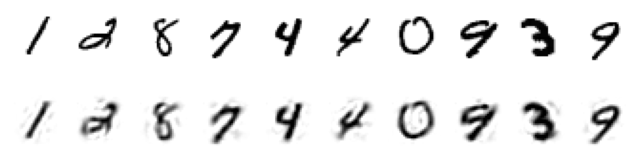

In [307]:
#### Plot outputs of autoencoder:
#########
fig1, ax1 = plt.subplots(2, 10, figsize=(8,2))

#And plot:
for i in range(10):

    im = ax1[0, i].imshow(X_valid[i], cmap='gray_r')
    ax1[0, i].set_axis_off()

    #And reconstruction:
    image = model_auto.predict(X_valid[i:i+1])
    
    #Can clip to 0, 1:
    image = np.clip(image, 0, 1)
    
    ax1[1, i].imshow(image.squeeze(), cmap='gray_r')
    ax1[1, i].set_axis_off()

### Use for transfer learning:

In [309]:
#Clone the architecture again
#Just copy and paste from above
model_clone = tf.keras.models.clone_model(model_auto)

#And now get the weights:
model_clone.set_weights(model_auto.get_weights())

In [310]:
## Now make a new model 89:
## Get all the layers from the autoencoder model
model_89_auto = tf.keras.Sequential(model_clone.layers[:-1])

#Just change output layer:
model_89_auto.add(tf.keras.layers.Dense(1, activation="sigmoid"))

In [311]:
## Make our hidden layers untrainable:
for layer in model_89_auto.layers[:-1]:
    layer.trainable=False

In [312]:
#Comile and train the new model:
#########

model_89_auto.compile(loss="binary_crossentropy",
              optimizer="sgd",
              metrics="accuracy")


In [314]:
## Try now:
model_89_auto.fit(X_train_89, y_train_89, epochs=100, validation_data=(X_valid_89, y_valid_89))

Epoch 1/100
4/4 [==============================] - 0s 16ms/step - loss: 0.4458 - accuracy: 0.9100 - val_loss: 0.4349 - val_accuracy: 0.8900
Epoch 2/100
4/4 [==============================] - 0s 9ms/step - loss: 0.4319 - accuracy: 0.9200 - val_loss: 0.4214 - val_accuracy: 0.8900
Epoch 3/100
4/4 [==============================] - 0s 9ms/step - loss: 0.4192 - accuracy: 0.9200 - val_loss: 0.4135 - val_accuracy: 0.8900
Epoch 4/100
4/4 [==============================] - 0s 9ms/step - loss: 0.4023 - accuracy: 0.9300 - val_loss: 0.3999 - val_accuracy: 0.8900
Epoch 5/100
4/4 [==============================] - 0s 9ms/step - loss: 0.3911 - accuracy: 0.9300 - val_loss: 0.4064 - val_accuracy: 0.8800
Epoch 6/100
4/4 [==============================] - 0s 9ms/step - loss: 0.3790 - accuracy: 0.9200 - val_loss: 0.4117 - val_accuracy: 0.8500
Epoch 7/100
4/4 [==============================] - 0s 9ms/step - loss: 0.3702 - accuracy: 0.9200 - val_loss: 0.4028 - val_accuracy: 0.8500
Epoch 8/100
4/4 [=========

4/4 [==============================] - 0s 9ms/step - loss: 0.1814 - accuracy: 0.9600 - val_loss: 0.2386 - val_accuracy: 0.9200
Epoch 60/100
4/4 [==============================] - 0s 9ms/step - loss: 0.1791 - accuracy: 0.9600 - val_loss: 0.2369 - val_accuracy: 0.9200
Epoch 61/100
4/4 [==============================] - 0s 9ms/step - loss: 0.1780 - accuracy: 0.9600 - val_loss: 0.2329 - val_accuracy: 0.9200
Epoch 62/100
4/4 [==============================] - 0s 9ms/step - loss: 0.1765 - accuracy: 0.9600 - val_loss: 0.2347 - val_accuracy: 0.9200
Epoch 63/100
4/4 [==============================] - 0s 9ms/step - loss: 0.1756 - accuracy: 0.9600 - val_loss: 0.2374 - val_accuracy: 0.9200
Epoch 64/100
4/4 [==============================] - 0s 9ms/step - loss: 0.1741 - accuracy: 0.9600 - val_loss: 0.2354 - val_accuracy: 0.9200
Epoch 65/100
4/4 [==============================] - 0s 9ms/step - loss: 0.1729 - accuracy: 0.9600 - val_loss: 0.2317 - val_accuracy: 0.9300
Epoch 66/100
4/4 [===============

In [317]:
#And make a layer trainable:
model_89_auto.layers[-2].trainable = True

In [327]:
#Can maybe do slightly better
model_89_auto.fit(X_train_89, y_train_89, epochs=10, validation_data=(X_valid_89, y_valid_89))

Epoch 1/10
4/4 [==============================] - 0s 17ms/step - loss: 0.1025 - accuracy: 0.9700 - val_loss: 0.1975 - val_accuracy: 0.9300
Epoch 2/10
4/4 [==============================] - 0s 9ms/step - loss: 0.1024 - accuracy: 0.9700 - val_loss: 0.1982 - val_accuracy: 0.9300
Epoch 3/10
4/4 [==============================] - 0s 9ms/step - loss: 0.1020 - accuracy: 0.9700 - val_loss: 0.1974 - val_accuracy: 0.9300
Epoch 4/10
4/4 [==============================] - 0s 9ms/step - loss: 0.1017 - accuracy: 0.9700 - val_loss: 0.1964 - val_accuracy: 0.9300
Epoch 5/10
4/4 [==============================] - 0s 9ms/step - loss: 0.1016 - accuracy: 0.9700 - val_loss: 0.1968 - val_accuracy: 0.9300
Epoch 6/10
4/4 [==============================] - 0s 10ms/step - loss: 0.1016 - accuracy: 0.9700 - val_loss: 0.1963 - val_accuracy: 0.9300
Epoch 7/10
4/4 [==============================] - 0s 9ms/step - loss: 0.1009 - accuracy: 0.9700 - val_loss: 0.1961 - val_accuracy: 0.9300
Epoch 8/10
4/4 [================

### Use autoencoding layers for classifier on all digits:

- Just a 'lil more copy and paste:

In [328]:
#Clone the architecture again
#Just copy and paste from above
model_clone = tf.keras.models.clone_model(model_auto)

#And now get the weights:
model_clone.set_weights(model_auto.get_weights())

In [333]:
## Now make a new model 89:
## Get all the layers from the autoencoder model
model_all_auto = tf.keras.Sequential(model_clone.layers[:-1])

#Just change output layer:
model_all_auto.add(tf.keras.layers.Dense(10, activation="softmax"))

In [334]:
## Make our hidden layers untrainable:
for layer in model_all_auto.layers[:-1]:
    layer.trainable=False

In [335]:
#Comile and train the new model:
#########

model_all_auto.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics="accuracy")


In [336]:
## Try now:
model_all_auto.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.8124 - accuracy: 0.8124 - val_loss: 0.4324 - val_accuracy: 0.9076
Epoch 2/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4771 - accuracy: 0.8766 - val_loss: 0.3506 - val_accuracy: 0.9136
Epoch 3/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4236 - accuracy: 0.8861 - val_loss: 0.3202 - val_accuracy: 0.9152
Epoch 4/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3974 - accuracy: 0.8903 - val_loss: 0.3031 - val_accuracy: 0.9192
Epoch 5/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3813 - accuracy: 0.8936 - val_loss: 0.2927 - val_accuracy: 0.9208
Epoch 6/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3701 - accuracy: 0.8954 - val_loss: 0.2845 - val_accuracy: 0.9236
Epoch 7/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3618 - accuracy: 0.8975 - val_loss: 0.2787 - val_accuracy: